In [1743]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [1744]:
s = ctl.TransferFunction.s
G = 0.0241097084013745*(0.179457496*s**2 - 0.44939551*s + 1.0)/(0.1794575*s**2 - 0.84724848*s + 1.0)

G_bpk = G
G

TransferFunction(array([ 0.00432667, -0.01083479,  0.02410971]), array([ 0.1794575 , -0.84724848,  1.        ]))

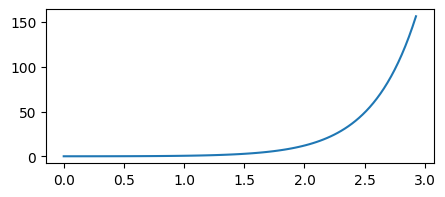

In [1745]:
time, response = ctl.step_response(G)
plt.figure(figsize=(5, 2))
plt.plot(time, response)

- Encontrando as características da resposta transitória e permanente

In [1746]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  0.0
valor de pico:  156.4363109058122
tempo de pico:  2.926292633721661
tempo de assentamento:  None
valor final:  156.4363109058122
erro:  155.4363109058122


- Encontrando os polos do sistema

In [1747]:
polos = ctl.pole(G)
zeros = ctl.zeros(G)

print(polos)
print(zeros)

[2.36058253+0.00031935j 2.36058253-0.00031935j]
[1.25209456+2.001152j 1.25209456-2.001152j]


In [1748]:
most_distant_pole = np.real(min([min(polos), min(zeros)]))
most_distant_pole

1.2520945628261746

# ENCONTRANDO OS PARÂMETROS DESEJADOS
- O primeiro parâmetero é que o erro seja nulo, ou seja $c(\infty) = \lim_{t \to \infty} c(t) = \lim_{s \to 0} s\,C(s) = \lim_{s \to 0} s\,G(s)R(s)= 0$

- O segundo parâmetro se refere à resposta transitória do sistema, ou seja, queremos alguma informação da resposta transitória que nos dê $\zeta$. Um bom parâmetro é o tempo de estabilização $T_s$, gostaria que $T_s$ fosse pequeno.

$\omega_n = \frac{2\pi}{T_s}$


In [1749]:
Ts = 10
UP = .2

In [1750]:
zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
zeta

0.4559498107691261

In [1751]:
Wn = 2*np.pi/Ts
Wn

0.6283185307179586

- Uma maneira de encontrar o polo desejado $s_D$ para o controlador é encontrando a interseção da linha vertical projetada por $\zeta$ com o caminho percorrido pelo LGR

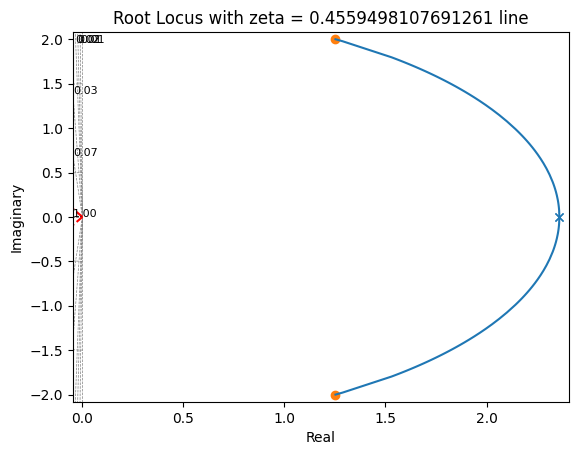

In [1752]:
def zGrid(G, zeta):
    ctl.root_locus(G)

    angle  = np.arccos(zeta)
    radius = np.linspace(0, 100, 400)

    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    
    plt.plot(-x, y, 'r--')
    plt.plot(-x, -y, 'r--')

    plt.title(f'Root Locus with zeta = {zeta} line')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.show()

zGrid(G, zeta)

- Uma outra forma é usar a relação: $s = -\zeta\omega_n \pm \omega_n\sqrt{1-\zeta^2}j$

In [1753]:
s1 = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*sp.I
s2 = -zeta*Wn - Wn*np.sqrt(1-zeta**2)*sp.I

s_desired = s1
s_desired

-0.286481715183589 + 0.559206941041546*I

# IMPLEMENTANDO O CONTROLADOR PID
- Encontrando as constantes do controlador: $C(s) = K\frac{(s-a)(s-b)}{s}$

In [1754]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=15):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

In [1755]:
s = sp.symbols('s')
K, a, b, p = sp.symbols('K a b p', real=True)

G = sympyFunction(G)
G

(0.00432666789900083*s**2 - 0.010834794702987*s + 0.0241097084013745)/(0.1794575*s**2 - 0.84724848*s + 1.0)

- A função de transferência final em malha aberta será $G(s)C(s)$
- O $p$ tem que ser de 5 a 10 vezes mais distante do que os polos e zeros do controlador

In [1756]:
C = K * ((s - a) * (s - b)) / (s * (s + 10))
GC = G * C

GC

K*(-a + s)*(-b + s)*(0.00432666789900083*s**2 - 0.010834794702987*s + 0.0241097084013745)/(s*(s + 10)*(0.1794575*s**2 - 0.84724848*s + 1.0))

In [1757]:
ZERO = 1e-10

- Erro em regime permanente para entrada em degrau é igual a zero (malha fechada)

$erro = \frac{1}{1+K_p}$ onde $K_p = \lim_{s\to 0} G(s)$

In [1758]:
Kp  = GC.subs(s, ZERO).expand().simplify()
eq1 = 1/(1 + Kp)
eq1 = sp.Eq(eq1, ZERO)
eq1

Eq(1/(K*(24109708.4020926*a*b - 0.00241097084020926*a - 0.00241097084020926*b + 2.41097084020926e-13) + 1), 1.0e-10)

- A soma dos angulos da função de transferência em malha aberta + 180º é igual a zero para o $s$ desejado

In [1759]:
G_aux = GC.subs(s, s_desired)
angle = sp.arg(G_aux)

eq2 = sp.Eq(angle + sp.pi, ZERO)
eq2

Eq(arg(-K*(0.286481715183589 + 0.559206941041546*I)*(9.71351828481641 - 0.559206941041546*I)*(0.0272136789715483 - 0.0060588924026705*I + 0.00432666789900083*(-0.286481715183589 + 0.559206941041546*I)**2)*(-a - 0.286481715183589 + 0.559206941041546*I)*(-b - 0.286481715183589 + 0.559206941041546*I)/(1.24272119773709 - 0.4737872308029*I + 0.1794575*(-0.286481715183589 + 0.559206941041546*I)**2)) + pi, 1.0e-10)

- O módulo da função de transferência em malha aberta é igual a 1 para o $s$ desejado

In [1760]:
G_aux  = GC.subs(s, s_desired)
modulo = sp.Abs(G_aux).expand().simplify()
eq3    = sp.Eq(modulo - 1, ZERO)
eq3

Eq(0.00339373887172597*sqrt(a**2 + 0.572963430367177*a + 0.394784176043574)*sqrt(b**2 + 0.572963430367177*b + 0.394784176043574)*Abs(K) - 1, 1.0e-10)

In [1761]:
def convertString(eq):
    return str(eq.lhs).replace('sqrt', 'np.sqrt').replace('Abs', 'np.abs').replace('pi', 'np.pi').replace('arg', 'np.angle').replace('*I', 'j').replace('I)', '1j)')

str_eq1 = convertString(eq1)
str_eq2 = convertString(eq2)
str_eq3 = convertString(eq3)

print(str_eq1)
print(str_eq2)
print(str_eq3)

1/(K*(24109708.4020926*a*b - 0.00241097084020926*a - 0.00241097084020926*b + 2.41097084020926e-13) + 1)
np.angle(-K*(0.286481715183589 + 0.559206941041546j)*(9.71351828481641 - 0.559206941041546j)*(0.0272136789715483 - 0.0060588924026705j + 0.00432666789900083*(-0.286481715183589 + 0.559206941041546j)**2)*(-a - 0.286481715183589 + 0.559206941041546j)*(-b - 0.286481715183589 + 0.559206941041546j)/(1.24272119773709 - 0.4737872308029j + 0.1794575*(-0.286481715183589 + 0.559206941041546j)**2)) + np.pi
0.00339373887172597*np.sqrt(a**2 + 0.572963430367177*a + 0.394784176043574)*np.sqrt(b**2 + 0.572963430367177*b + 0.394784176043574)*np.abs(K) - 1


In [1762]:
def sistema(variaveis):
    (K, a, b) = variaveis
    return [
        eval(str_eq1), 
        eval(str_eq2),
        eval(str_eq3)
    ]

solutions = fsolve(sistema, [1, 1, 1], maxfev=100000, xtol=ZERO)
print('Solucoes:', solutions, '\n')

Solucoes: [287.89977411   0.44840928   0.67030514] 



In [1763]:
for eq in [eq1, eq2, eq3]:
    sol = eq.lhs.subs({
        K: solutions[0],
        a: solutions[1],
        b: solutions[2]
    })
    print(float(sol))

4.793134130404919e-10
0.00014661414939293738
-8.322975642782726e-05


In [1764]:
K = solutions[0]
a = solutions[1]
b = solutions[2]

- Função de transferência do controlador $C(s)$

In [1765]:
s = ctl.TransferFunction.s
C = K * ((s - a) * (s - b)) / (s * (s + 10))

print(sympyFunction(C))
C

(287.899774108004*s**2 - 322.077626860205*s + 86.5343348444173)/(s**2 + 10*s)


TransferFunction(array([ 287.89977411, -322.07762686,   86.53433484]), array([ 1, 10,  0]))

- Função de transferência do sistema em malha aberta $C(s)G(s)$

In [1766]:
G  = G_bpk
GC = G*C
GC

TransferFunction(array([ 1.24564671, -4.51285788, 10.8052299 , -8.70277942,  2.08631758]), array([ 0.1794575 ,  0.94732652, -7.4724848 , 10.        ,  0.        ]))

- Função de transferência em malha fechada com realimentação unitária $G_{feedback}(s) = \frac{G(s)C(s)}{1+G(s)C(s)}$

In [1767]:
G_feedback = ctl.feedback(GC, 1)
G_feedback

TransferFunction(array([ 1.24564671, -4.51285788, 10.8052299 , -8.70277942,  2.08631758]), array([ 1.42510421, -3.56553136,  3.3327451 ,  1.29722058,  2.08631758]))

In [1768]:
ctl.poles(G_feedback)

array([ 1.53760864+1.15858891j,  1.53760864-1.15858891j,
       -0.28663649+0.55929185j, -0.28663649-0.55929185j])

# APLICANDO UM STEP

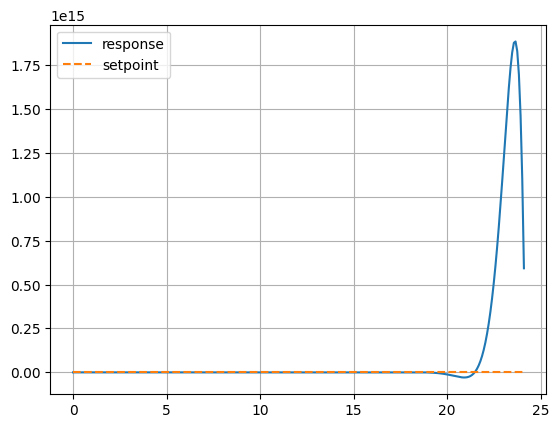

In [1769]:
time, response = ctl.step_response(G_feedback)
plt.plot(time, response, label='response')
plt.plot(time, [1 for i in time], '--', label='setpoint')
plt.legend()
plt.grid()

In [1770]:
getAllInfo(time, response, setpoint=1)

overshoot:  2.179423631723795
valor de pico:  1883866288542424.8
tempo de pico:  23.65141401138559
tempo de assentamento:  None
valor final:  592518175226949.9
erro:  592518175226948.9


# APLICANDO VÁRIOS STEPS

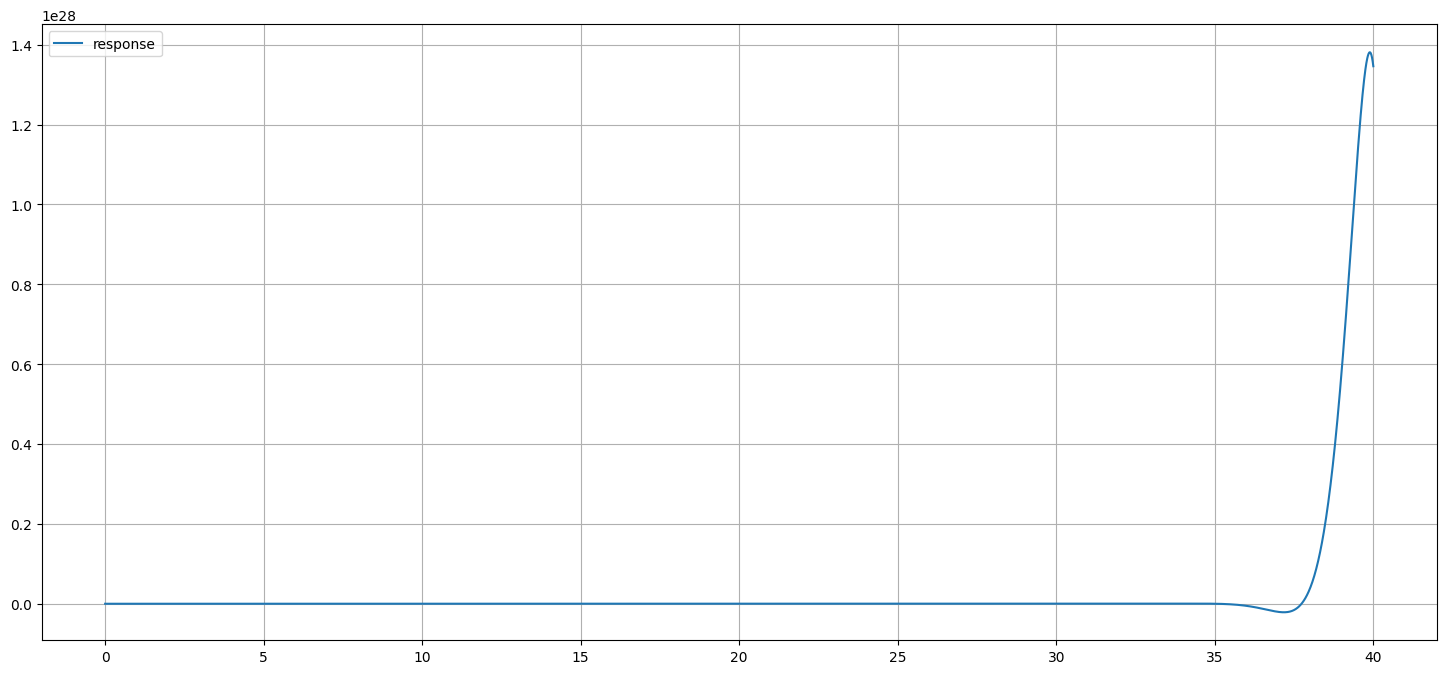

In [1771]:
uData = [100 for i in range(1000)] + [0 for i in range(1000)] + [-100 for i in range(1000)] + [50 for i in range(1000)]
tData = np.linspace(0, 40, len(uData))

plt.figure(figsize=(18, 8))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.legend()
plt.grid()